# Digit Recognition

## 1. Introduction

In this analysis, the handwritten digits are identified using support vector machines and radial basis functions.

### 1.1 Libraries

The essential libraries used here are numpy, matplotlib, and scikit-learn.  For convenience, pandas and IPython.display are used for displaying tables, and tqdm is used for progress bars.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit, KFold
from tqdm import tqdm
from IPython.display import display, Math, Latex, HTML
%matplotlib inline
np.set_printoptions(precision=4,threshold=200)
tqdm_bar_fmt='{percentage:3.0f}%|{bar}|'

### 1.2 Dataset

The US Postal Service Zip Code dataset is used, which contains handwritten digits zero to nine.  The data has been preprocessed, whereby features of intensity and symmetry are extracted.

In [2]:
def download_data():
    train_url = "http://www.amlbook.com/data/zip/features.train"
    test_url  = "http://www.amlbook.com/data/zip/features.test"
    column_names = ['digit','intensity','symmetry']
    train = pd.read_table(train_url,names=column_names,header=None,delim_whitespace=True)
    test = pd.read_table(test_url,names=column_names,header=None,delim_whitespace=True)
    train.digit = train.digit.astype(int)
    test.digit = test.digit.astype(int)
    return train,test

def process_data(train,test):
    X_train = train.iloc[:,1:].values
    y_train = train.iloc[:,0].values
    X_test = test.iloc[:,1:].values
    y_test = test.iloc[:,0].values
    return X_train,y_train,X_test,y_test

In [3]:
train,test = download_data()
X_train,y_train,X_test,y_test = process_data(train,test)

## 2. Support Vector Machines for Digit Recognition

### 2.1 Polynomial Kernels

We wish to implement the following polynomial kernel for our support vector machine:

$$K\left(\mathbf{x_n,x_m}\right) = \left(1+\mathbf{x_n^Tx_m}\right)^Q$$

This is implemented in scikit-learn in the subroutine [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/svm.html), where the kernel function takes the form:

$$\left(\gamma \langle x,x' \rangle + r\right)^d$$

where $d$ is specified by the keyword `degree`, and $r$ by `coef0`.

### 2.1.1 One vs Rest Classification
In the following subroutine, the data is split into "one-vs-rest", where $y=1$ corresponds to a match to the digit, and $y=0$ corresponds to all the other digits.  The training step is implemented in the call to `clf.fit()`.

In [4]:
def get_misclassification_ovr(X_train,y_train,X_test,y_test,digit,
                              Q=2,r=1.0,C=0.01,kernel='poly',verbose=False):
    clf = SVC(C=C, kernel=kernel, degree=Q, coef0 = r, gamma = 1.0,
          decision_function_shape='ovr', verbose=False)
    y_in  = (y_train==digit).astype(int)
    y_out = (y_test==digit).astype(int)
    model = clf.fit(X_train,y_in)  # print(model)
    E_in  = np.mean(y_in  != clf.predict(X_train))
    E_out = np.mean(y_out != clf.predict(X_test))
    n_support_vectors = len(clf.support_vectors_)
    if verbose is True:
        print()
        print("Q = {}, C = {}: Support vectors: {}".format(Q, C, n_support_vectors))
        print("{} vs all: E_in  = {}".format(digit,E_in))
        print("{} vs all: E_out = {}".format(digit,E_out))
    return E_in,E_out,n_support_vectors

The following code trains on the data for the cases: 0 vs all, 1 vs all, ..., 9 vs all.  For each of the digits, 0 to 9, the errors $E_{in}, E_{out}$ and the number of support vectors are recorded and stored in a pandas dataframe.

In [5]:
results = pd.DataFrame()
i=0
for digit in tqdm(range(10),bar_format=tqdm_bar_fmt):
    ei, eo, n = get_misclassification_ovr(X_train,y_train,X_test,y_test,digit)
    df = pd.DataFrame({'digit': digit, 'E_in': ei, 'E_out': eo, 'n': n}, index=[i])
    results = results.append(df)
    i += 1

100%|██████████|


In [6]:
display(HTML(results[['digit','E_in','E_out','n']].iloc[::2].to_html(index=False)))

digit,E_in,E_out,n
0,0.105884,0.111609,2179
2,0.100261,0.098655,1970
4,0.089425,0.099651,1856
6,0.091071,0.084704,1893
8,0.074338,0.082711,1776


In [7]:
display(HTML(results[['digit','E_in','E_out','n']].iloc[1::2].to_html(index=False)))

digit,E_in,E_out,n
1,0.014401,0.021923,386
3,0.090248,0.082711,1950
5,0.076258,0.079721,1585
7,0.088465,0.073244,1704
9,0.088328,0.088191,1978


In [8]:
from tabulate import tabulate
print(tabulate(results, headers='keys', tablefmt='simple'))

         E_in      E_out    digit     n
--  ---------  ---------  -------  ----
 0  0.105884   0.111609         0  2179
 1  0.0144013  0.0219233        1   386
 2  0.100261   0.0986547        2  1970
 3  0.0902483  0.0827105        3  1950
 4  0.0894253  0.0996512        4  1856
 5  0.0762584  0.079721         5  1585
 6  0.0910712  0.0847035        6  1893
 7  0.0884652  0.0732436        7  1704
 8  0.0743382  0.0827105        8  1776
 9  0.0883281  0.0881913        9  1978


### 2.1.2 One vs One Classification

One vs one classification makes better use of the data, but is more computatationally expensive.  The following subroutine splits the data so that $y=0$ for the first digit, and $y=1$ for the second digit.  The rows of data corresponding to all other digits are removed.

In [9]:
def get_misclassification_ovo(X_train,y_train,X_test,y_test,digit1,digit2,
                              Q=2,r=1.0,C=0.01,kernel='poly'):
    clf = SVC(C=C, kernel=kernel, degree=Q, coef0 = r, gamma = 1.0,
          decision_function_shape='ovo', verbose=False)
    select_in = np.logical_or(y_train==digit1,y_train==digit2)
    y_in  = (y_train[select_in]==digit1).astype(int)
    X_in  =  X_train[select_in]
    select_out = np.logical_or(y_test==digit1,y_test==digit2)
    y_out = (y_test[select_out]==digit1).astype(int)
    X_out =  X_test[select_out]
    model = clf.fit(X_in,y_in)

    E_in  = np.mean(y_in  != clf.predict(X_in))
    E_out = np.mean(y_out != clf.predict(X_out))
    n_support_vectors = len(clf.support_vectors_)
    return E_in,E_out,n_support_vectors

In the following code, a 1-vs-5 classifier is tested for $Q=2,5$ and $C=0.001,0.01,0.1,1$.

In [10]:
C_arr = [0.0001, 0.001, 0.01, 1]
Q_arr = [2, 5]
CQ_arr = list(product(C_arr,Q_arr))
results = pd.DataFrame()
i=0
for C, Q in tqdm(CQ_arr,bar_format=tqdm_bar_fmt):
    ei, eo, n = get_misclassification_ovo(X_train,y_train,X_test,y_test,
                                          digit1=1,digit2=5,Q=Q,r=1.0,C=C)
    df = pd.DataFrame({'C': C, 'Q': Q, 'E_in': ei, 'E_out': eo, 'n': n}, index=[i])
    results = results.append(df)
    i += 1
display(HTML(results[['C','Q','E_in','E_out','n']].to_html(index=False)))

100%|██████████|


C,Q,E_in,E_out,n
0.0001,2,0.008969,0.016509,236
0.0001,5,0.004484,0.018868,26
0.0010,2,0.004484,0.016509,76
0.0010,5,0.004484,0.021226,25
0.0100,2,0.004484,0.018868,34
0.0100,5,0.003844,0.021226,23
1.0000,2,0.003203,0.018868,24
1.0000,5,0.003203,0.021226,21


### 2.1.3 Polynomial Kernel with Cross-Validation

For k-fold cross-validation, the subroutine [`sklearn.model_selection.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)`()` is employed to split the data into folds.  Random shuffling is enabled with the `shuffle=True` option.

In [11]:
def select_digits_ovo(X,y,digit1,digit2):
    subset = np.logical_or(y==digit1,y==digit2)
    X_in  =  X[subset].copy()
    y_in  = (y[subset]==digit1).astype(int).copy()
    return X_in,y_in

In [12]:
def get_misclassification_ovo_cv(X_in,y_in,Q=2,r=1.0,C=0.01,kernel='poly'):
    kf = KFold(n_splits=10, shuffle=True)
    kf.get_n_splits(X_in)
    E_cv = []
    for train_index, test_index in kf.split(X_in):
        X_trn, X_tst = X_in[train_index], X_in[test_index]
        y_trn, y_tst = y_in[train_index], y_in[test_index]
        clf = SVC(C=C, kernel=kernel, degree=Q, coef0 = r, gamma = 1.0,
              decision_function_shape='ovo', verbose=False)
        model = clf.fit(X_trn,y_trn)
        E_cv.append(np.mean(y_tst != clf.predict(X_tst)))
    return E_cv

In this example, our parameters are $Q=2, C \in \{0.0001,0.001,0.01,0.1,1\}$ and we are considering the 1-vs-5 classifier.

In [13]:
C_arr = [0.0001, 0.001, 0.01, 0.1, 1]; d1 = 1; d2 = 5
Q=2
X_in,y_in = select_digits_ovo(X_train,y_train,d1,d2)

Due to the effect of random shuffling, 100 runs are carried out, and the results tabulated.

In [14]:
E_cv_arr = []
count_arr = []
for n in tqdm(range(100),bar_format=tqdm_bar_fmt):
    counts = np.zeros(len(C_arr),int)
    kf = KFold(n_splits=10, shuffle=True)
    kf.get_n_splits(X_in)
    for train_index, test_index in kf.split(X_in):
        X_trn, X_tst = X_in[train_index], X_in[test_index]
        y_trn, y_tst = y_in[train_index], y_in[test_index]
        E_cv = []
        for C in C_arr:
            clf = SVC(C=C, kernel='poly', degree=Q, coef0=1.0, gamma=1.0,
                  decision_function_shape='ovo', verbose=False)
            model = clf.fit(X_trn,y_trn)
            E_cv.append(np.mean(y_tst != clf.predict(X_tst)))
        counts[np.argmin(E_cv)] += 1
        E_cv_arr.append(np.array(E_cv))
    count_arr.append(counts)

100%|██████████|


The number of times each particular value of $C$ is picked (for having the smallest $E_{cv}$) is calculated, as well as the mean cross validation error.  The data is tabulated as follows:

In [15]:
df = pd.DataFrame({'C': C_arr})
df['count'] = np.sum(np.array(count_arr),axis=0)
df['E_cv']  = np.mean(np.array(E_cv_arr),axis=0)
display(HTML(df.to_html(index=False)))

C,count,E_cv
0.0001,383,0.009808
0.0010,506,0.004785
0.0100,47,0.004696
0.1000,29,0.004760
1.0000,35,0.004901


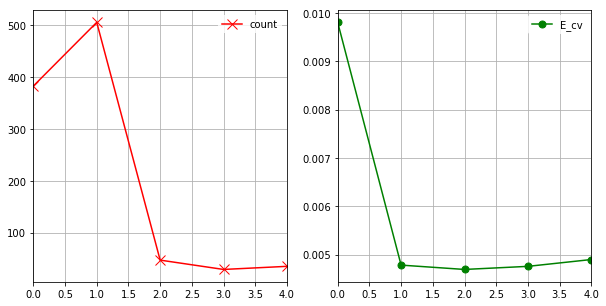

In [16]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
_ = df.plot(y=['count'],ax=ax1,marker='x',color='red',markersize=10,grid=True)
ax2 = fig.add_subplot(122)
_ = df.plot(y=['E_cv'],ax=ax2,marker='o',color='green',markersize=7,grid=True)

### 2.2 Scaling Law for Support Vector Machines

This is based on [scikit-learn example code](http://scikit-learn.org/stable/tutorial/basic/tutorial.html), but modified to demonstrate how the training time scales with the size of the data.  The dataset in this example is the original MNIST data.

In [17]:
from sklearn.datasets import fetch_mldata
from sklearn import svm
import timeit
digits = fetch_mldata('MNIST original')  # stores data in ~/scikit_learn_data by default
n_max = len(digits.target)
selection = np.random.permutation(n_max)

In [18]:
n_arr = [500, 1000, 1500, 2000, 5000, 10000]
t_arr = []
for n in n_arr:
    sel = selection[:n]
    X = digits.data[sel]
    y = digits.target[sel]
    clf = svm.SVC(gamma=0.001, C=100.)
    t0 = timeit.default_timer()
    clf.fit(X,y)
    t_arr.append(timeit.default_timer() - t0)
    print("n = {}, time = {}".format(n, t_arr[-1]))

n = 500, time = 0.3734194010030478
n = 1000, time = 1.5319869879167527
n = 1500, time = 3.259773097001016
n = 2000, time = 5.597098698024638
n = 5000, time = 36.763241220032796
n = 10000, time = 146.17572045407724


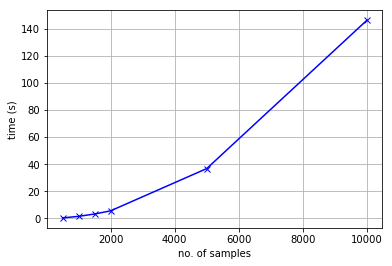

In [19]:
plt.plot(np.array(n_arr),np.array(t_arr),'bx-')
plt.xlabel('no. of samples')
plt.ylabel('time (s)')
plt.grid()

## 3. Radial Basis Functions

### 3.1 Background

The hypothesis is given by:

$$h\left(\mathbf{x}\right) = \sum\limits_{k=1}^K w_k \exp\left(-\gamma \Vert \mathbf{x} - \mu_k \Vert^2\right)$$

This is implemented in the subroutine [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/svm.html)`(..., kernel='rbf', ...)` as shown in the code below.

In [20]:
def get_misclassification_rbf(X_train,y_train,X_test,y_test,C,digit1=1,digit2=5):
    clf = SVC(C=C, kernel='rbf', gamma = 1.0,
          decision_function_shape='ovo', verbose=False)
    select_in = np.logical_or(y_train==digit1,y_train==digit2)
    y_in  = (y_train[select_in]==digit1).astype(float)
    X_in  =  X_train[select_in]
    select_out = np.logical_or(y_test==digit1,y_test==digit2)
    y_out = (y_test[select_out]==digit1).astype(float)
    X_out =  X_test[select_out]
    model = clf.fit(X_in,y_in)
    E_in  = np.mean(y_in  != clf.predict(X_in))
    E_out = np.mean(y_out != clf.predict(X_out))
    n_support_vectors = len(clf.support_vectors_)
    return E_in,E_out,n_support_vectors

For $C \in \{0.01, 1, 100, 10^4, 10^6\}$, the in-sample and out-of-sample errors, as well as the number of support vectors are tabulated as follows:

In [21]:
C_arr = [0.01, 1., 100., 1e4, 1e6]
results = pd.DataFrame()
i=0
for C in tqdm(C_arr,bar_format=tqdm_bar_fmt):
    ei, eo, n = get_misclassification_rbf(X_train,y_train,X_test,y_test,
                                          C,digit1=1,digit2=5)
    df = pd.DataFrame({'C': C, 'E_in': ei, 'E_out': eo, 'n': n}, index=[i])
    results = results.append(df)
    i += 1
display(HTML(results.to_html(index=False)))

100%|██████████|


C,E_in,E_out,n
0.01,0.003844,0.023585,406
1.00,0.004484,0.021226,31
100.00,0.003203,0.018868,22
10000.00,0.002562,0.023585,19
1000000.00,0.000641,0.023585,17


The table is also plotted graphically below:

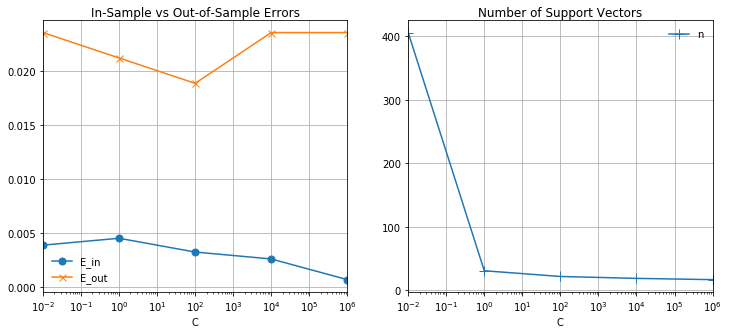

In [22]:
def plot_Ein_Eout(df):
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    df.plot(ax=ax1, x='C', y='E_in', kind='line', marker='o', markersize=7, logx=True)
    df.plot(ax=ax1, x='C', y='E_out', kind='line', marker='x', markersize=7, logx=True)
    ax1.legend(loc='best',frameon=False)
    ax1.grid(True)
    ax1.set_title('In-Sample vs Out-of-Sample Errors')

    ax2 = fig.add_subplot(122)
    df.plot(ax=ax2, x='C', y='n', kind='line', marker='+', markersize=10, logx=True)
    ax2.legend(loc='best',frameon=False)
    ax2.grid(True)
    ax2.set_title('Number of Support Vectors')

plot_Ein_Eout(results)